# Simultaneous value coding by a neural network

This project formed part of my [paper](https://www.biorxiv.org/content/10.1101/2021.10.08.463476v1) characterising the link between neural network activity and the value of items.The original data was collected by other researchers (available [here](https://crcns.org/data-sets/pfc/pfc-7/about-pfc-7)), and I have conducted the analysis of it.

Here, we'll analyse firing rates from anterior cingulage cortex (ACC) neurons, an area of the brain known to encode the value of objects. Data are taken from a task where there are four images on the screen, one currently being viewed and three other in the peripheral vision. Each image can represent one of five different values. We want to know how many of the four images on the screen the neuron network is encoding the value of at any one time point.

![image](task.png)

---
### Data visualisation

First load in the required modules and data. 

In [1]:
import numpy as np
import plot
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm

y = np.load('y.npy')  # Neuron firing rates [numNeurons x numTrials x Time]
x = np.load('x.npy')  # Value of 4 cues on each trial [numNeurons x numCues x numTrials]
time = range(-100, 1000, 10)  # Data is binned into 10 ms windows
tp = 25  # The example timepoint we shall use

Let's choose a random neuron and see how it's firing changes as a function of the image that they are currently looking at.

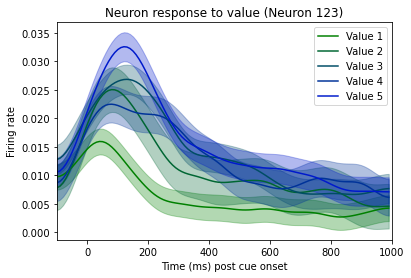

In [2]:
ineuron = 123
yy, xx = y[ineuron], x[ineuron, 0]

averages = [np.mean(yy[xx==val], axis=0) for val in np.unique(xx)]
sems = [np.std(yy[xx==val]) / np.sqrt(len(yy[xx==val])) for val in np.unique(xx)]

plot.plot1(averages, sems);
plt.title(f'Neuron response to value (Neuron {ineuron})');

Cool, we can see this neuron is encoding value of the cue currently looked at by increasing its firing rate for higher value images.

### Multiple linear regression

Lets quantify this using multiple linear regression. Our first model will just contain the value of the image looked at and an intercept parameter.

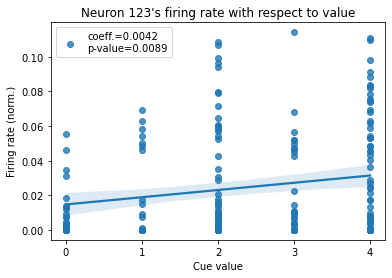

In [3]:
design_matrix = np.vstack((np.ones(len(xx)), xx)).T  # Add intercept
m = sm.OLS(yy[:, tp], design_matrix).fit()  # Fit the model
betas, pvals = m.params, m.pvalues  # Extract our statistics

#Plot 
sb.regplot(xx, yy[:, tp], label=f'coeff.={np.round(m.params[1], 4)}\np-value={np.round(pvals[1], 4)}')
plt.xlabel('Cue value'), plt.ylabel('Firing rate (norm.)'); plt.legend()
plt.xticks(range(5)); plt.xlim(-0.2, 4.2)
plt.title(f'Neuron {ineuron}\'s firing rate with respect to value');

We can see that the coefficient is very significant (p<.001) and thus value had a strong effect on this neurons firing rate. 

Now we want to perform our analysis over time to see how the information encoding persists in the network. If we were to continue using the Statsmodels package it would take a very long time as it includes lots of calculations that we are not interested in. 

Let's make our own efficient regression function instead. We'll use the dot product of the pseudoinverse of x to perform ordinary least squares regression in a vectorised manner, which is very fast.

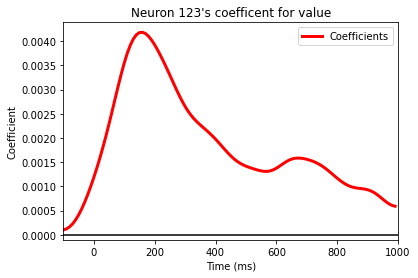

In [4]:
def reg(x, y):
    return np.dot(np.linalg.pinv(x), y)

coeffs = reg(design_matrix, yy)

#Plot
f, ax = plt.subplots(1)
ax.plot(time, coeffs[1], lw=3, label='Coefficients', c='red'); ax.axhline(0, c='k')
ax.set_ylabel('Coefficient'); ax.set_xlabel('Time (ms)'); ax.set_xlim(-100, 1000)
ax.legend(); ax.set_title(f'Neuron {ineuron}\'s coefficent for value');

### Coefficient of partial determination (CPD)

Cool we can see a nice clear peak where the coefficients increase. Just examining raw coefficients isn't a good measure of our model's fit, however, so we'll use the coefficient of partial determination (Rsquared) instead. This represents the percentage of additional variance that is explained by the model when including our parameter. Again, we'll create a vectorised function to enable us to do it efficiently.

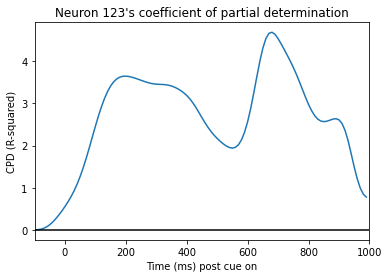

In [5]:
def cpd(x, y, i):
    bs = reg(x, y)  # Get coefficients
    pred = np.dot(x, bs)  # Get y-hat
    r = y - pred  # Get residuals (SSE)
    
    # Now get SSE without that column in our design matrix
    xred = np.delete(x, i, axis=1)  # Remove column
    bs2 = reg(xred, y)  # Get coeffs
    predred = np.dot(xred, bs2)  # Get y-hat
    rred = y - predred  # Get residuals (SSE)
    
    # Calculate percentage of additional variance explained by the parameter
    rsqr =  (np.sum(np.square(rred), axis=0) - np.sum(np.square(r), axis=0)) / np.sum(np.square(rred), axis=0)
    
    rsqr *= 100 # Convert from fraction to percentage
    
    return rsqr

rsqr = cpd(design_matrix, yy, 1)

# Plot
plt.plot(time, rsqr); plt.axhline(0, c='k'); plt.ylabel('CPD (R-squared)');
plt.xlabel('Time (ms) post cue on'); plt.xlim(-100, 1000)
plt.title(f'Neuron {ineuron}\'s coefficient of partial determination'); 

Great, we can  see that value explains a (relatively) large proportion of the variance for a long time after the cue first came on. Lets now compute the CPD for all our neurons and look at the average effect over the network. 

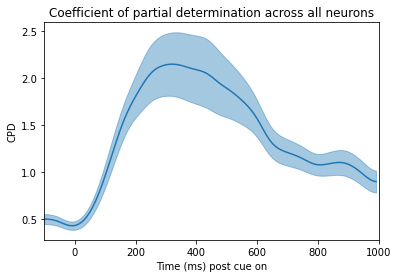

In [6]:
rsqrs = np.empty((len(y), y.shape[-1]))  # Make holding array

for ineur, (yneur,xneur) in enumerate(zip(y, x[:, 0])):  # For each neuron
    
    # Construct X and get resulting CPD
    design_matrix = np.vstack((np.ones(len(xneur)), xneur)).T
    rsqrs[ineur] = cpd(design_matrix, yneur, 1)

# Plot
avg, sem = np.mean(rsqrs,axis=0), np.std(rsqrs,axis=0) / np.sqrt(len(rsqrs))
f, ax= plt.subplots(1); ax.set_xlim(-100, 1000)
ax.plot(time, avg); ax.fill_between(time, avg-sem, avg+sem, color='C0', alpha=0.4)
plt.ylabel('CPD');plt.xlabel('Time (ms) post cue on');
plt.title(f'Coefficient of partial determination across all neurons'); 

As with our individual neuron, we can see the activity of this neural activity is strongly modulated by the value of the item they look at. 

### Simultaneous value encoding by the neural network

Let's now look at the effect of our other three parameters, the value of the other 3 other cues that were on the screen and in the monkey's peripheral vision. 

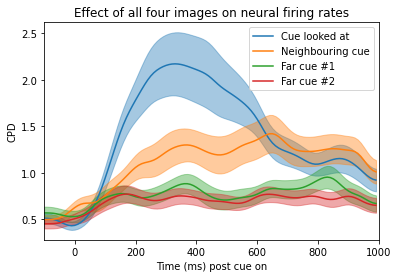

In [7]:
rsqrs = np.empty((4, len(y), y.shape[-1]))  # Holding array

for ineur, (yneur,xneur) in enumerate(zip(y, x)):  # For each neuron
    
    design_matrix = np.vstack((np.ones(len(xneur[0])), xneur)).T
    
    for iparam in range(4):
        rsqrs[iparam, ineur] = cpd(design_matrix, yneur, iparam+1)

avgRsqrs = np.mean(rsqrs, axis=1)  # Average Rsqr across neurons

# Plot
plot.avgsem(rsqrs);
plt.title('Effect of all four images on neural firing rates');

Awesome, these neurons are simultaneously encoding the value of all four cues simultaneously! This means items in the peripheral vision can still be evaluated by ACC neurons. 

### Permutation testing
Lets now statistically test whether all four parameters  actually significantly modulate the neural firing rates. A quick and rigorous way to do this is using permutation testing. Lets compute the null distribution of the CPD and compare it to our data. To do this we will shuffle the y-data across trials, so as to preserve both autocorrelations over time, and correlations between the different coefficients.

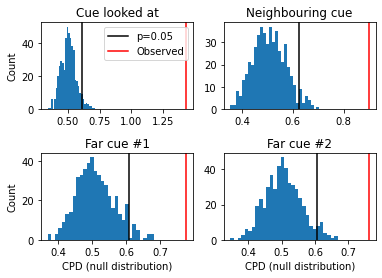

In [8]:
numperms = 500
nullDistribution = np.empty((4, len(y), y.shape[-1], numperms))  # Holding array

for ineur, (yneur,xneur) in enumerate(zip(y, x)):  # For each neuron
    
    design_matrix = np.vstack((np.ones(len(xneur[0])), xneur)).T
    
    for iperm in range(numperms):  # For each permutation
    
        np.random.shuffle(yneur)  # Shuffle the y data
        
        # Compute CPD for each parameter
        for iparam in range(4):
            nullDistribution[iparam, ineur, :, iperm] = cpd(design_matrix, yneur, iparam+1)

# Stats            
avgNullDist = np.mean(nullDistribution, axis=1)  # Average across neurons 
sortNullDist = np.sort(avgNullDist, axis=-1)  # Sort array 
thresholds = sortNullDist[:, :, int(numperms*0.95)]  # Find 95th percentile (p=0.05)

# Plot
plot.hist(avgNullDist, thresholds, avgRsqrs, tp);

Great, we can see that, for this time point, all four CPD values are outside of the null distribution, even for the cues in the distant peripheral vision. Therefore, there was a significant effect of all four cues on the firing rate of our neurons. Lets have a look at the statistics across all timepoints.

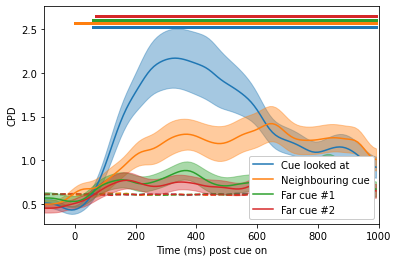

In [11]:
f, ax = plot.avgsem(rsqrs)
for iparam, (thresh, obs) in enumerate(zip(thresholds, avgRsqrs)):  # For each parameter
    
    # Find periods where the data crossed the threshold
    sig = obs > thresh  
    
    # Plot
    sig = np.array(sig,dtype=float) * (2.53 +(0.04*iparam))
    sig[sig==0]=np.nan;ax.plot(time, sig,c=f'C{iparam}', lw=3) 
    ax.plot(time,thresh,ls='--',c=f'C{iparam}', zorder=-1)
ax.legend(loc='lower right', framealpha=1);

Cool! So we can see that despite the fact that two of the cues are far away from where the monkey was looking, they still had a significant influence on the firing rate of the neurons (though less so than the near cue). Hence, the neural network within ACC is capable of responding to the value of four distinct items simultaneously ([full paper](https://www.biorxiv.org/content/10.1101/2021.10.08.463476v1)).